In [9]:
import numpy as np
import matplotlib.pyplot as plt

from include.load_data.get_counts import get_real_counts_by_county


from include.build_synth import buildData_fromRO as build

from include.estim.Rt_UnivariateOutliers import Rt_U_O
from include.estim.Rt_Univariate import myRt_U
from include.estim import Rt_Multivariate as RtM
from include.estim import laplacianLearning as LL
from include.estim import Rt_MLE as RtMLE
from include.estim import Rt_L



from importlib import reload
reload(RtM), reload(LL)

np.random.seed(2025)

In [2]:
from include.optim_tools.fidelity_terms_DKL import DKL_no_outlier as DKL
from include.optim_tools import crafting_phi,  opL, conversion_pymat as mat2py

Phi = crafting_phi()

def get_normalized_Zphi_and_Z(Z):
    nb_deps, days = Z.shape
    ZDataDep = np.zeros((nb_deps, days - 1))
    ZPhiNorm = np.zeros((nb_deps, days - 1))
    for d in range(nb_deps):
        _, ZDataDep[d], ZPhiDep = crafting_phi.buildZPhi(None, Z[d], Phi)
       
    # Normalizing for each 'département'
    std = np.std(ZDataDep, axis=1)
    ZDataNorm = ZDataDep / std[:,None]
    ZPhiNorm = ZPhiDep / std[:,None]
    return ZDataNorm, ZPhiNorm


def obj_function(R, L, ZDataNorm, ZPhiNorm, lambda_pwlin, lambda_GR, lambda_Fro):

    KL_term = DKL(R, ZDataNorm, ZPhiNorm)

    param_pwlin = mat2py.struct()
    param_pwlin.lambd = lambda_pwlin
    param_pwlin.type = '1D'
    pwlin_term = np.sum(np.abs(opL.opL(R, param_pwlin)))

    GR_term = lambda_GR * np.sum(R * (L @ R))

    Fro_term = lambda_Fro * np.sum(L**2)

    return KL_term + pwlin_term + GR_term + Fro_term







TypeError: 'module' object is not callable

In [ ]:
a = np.array([[1,2,3],[3,4,5]])
b = np.std(a, axis=1)
print(b.shape)

(2,)


In [ ]:
a / b[:,None]

array([[1.22474487, 2.44948974, 3.67423461],
       [3.67423461, 4.89897949, 6.12372436]])

## Disconnected complete graphs (french departments)
Define spatial clusters as disconnected complete graphs, with equal reproduction number in each cluster

In [3]:
firstDay, lastDay = "2020-12-01", "2021-02-10"
dataBasis = 'SPF'
country = "France"
allZData, options = get_real_counts_by_county(firstDay, lastDay, dataBasis)


In [65]:
names_by_clusters = [["22","29","56"],["40","64","65"],["38","73","74"]] # bretagne/ pyrénées ouest / alpes
# names_by_clusters = [["85","17","79"],["62","59","80"],["70","25","39"]] # vendée / Nord / Franche comté

cluster_sizes = [len(cluster) for cluster in names_by_clusters]
nclusters = len(names_by_clusters)

ZData = []
#extract data by depts
for cluster in names_by_clusters:
    for name in cluster:
        id = int(np.where(options["counties"]==name)[0][0])
        ZData.append(allZData[id])
ZData = np.array(ZData)


if np.sum(cluster_sizes)<=10:
    cmap = "tab10"
    colors = plt.get_cmap(cmap)(np.arange(np.sum(cluster_sizes)))
else:
    cmap = "rainbow"
    colors = plt.get_cmap(cmap)(np.linspace(0.05, 0.95,np.sum(cluster_sizes)))


## Generate ZData 
For each country, we generate new cases counts according to the reproduction number of their cluster

First day : 2020-12-01 
 Last day : 2021-02-10


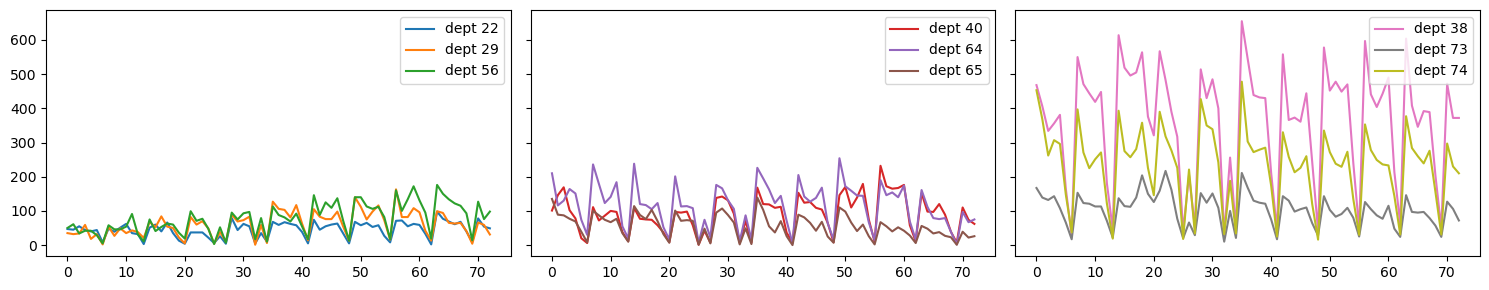

In [66]:
fig, axs = plt.subplots(1,nclusters, figsize=(15,3), sharex=True, sharey="row")
k = 0
for i in range(len(cluster_sizes)):
    for j in range(cluster_sizes[i]):
        axs[i].plot(ZData[k], color=colors[k], label="dept "+names_by_clusters[i][j])
        k+=1
    # axs[i].plot(ZData_by_cluster[i][1:], "k--", label="Original")
    
    axs[i].legend()
plt.tight_layout()
print("First day : {} \n Last day : {}".format(firstDay, lastDay) )

In [67]:
# get R estim with O as a reference
RestimUO = Rt_U_O(ZData, 3.5, 0.03, options=options)

Computing Univariate estimation with O misreported counts modelisation ...
Done in 28.2146 seconds ---


In [68]:
l = [1,2]
if len(l)<4:
    l = l + [l[-1]]*(4-len(l))
l

[1, 2, 2, 2]

In [69]:
reload(Rt_L)

n_max_iter = 5

#init param
init_method = "U"
init_param = {"options":options, "lambdaU_pwlin": 20}

#optim param
lambda_Fro = 0.25
lambda_GRs = [ [1.] , [0.1, 1.], [0.1, 0.5, 1.]]
lambda_pwlin = 20

various_Rs, various_Ls, various_objs = [], [], []
for lambda_GR in lambda_GRs:
    Restims, Lestims, _, objs = Rt_L.Rt_L(ZData, n_max_iter, lambda_pwlin, lambda_GR, lambda_Fro, options, init_method, init_param, save_objective=True)
    various_Rs.append(Restims), various_Ls.append(Lestims), various_objs.append(objs)



Computing Univariate estimator ...
Done in 8.9434 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 29.1648 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 30.0686 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 38.5431 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 34.2984 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 33.7691 seconds ---
Computing Univariate estimator ...
Done in 10.4300 seconds ---
lambda_GR = 0.100
Computing Multivariate estimator ...
Done in 35.3644 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 31.2947 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 35.5430 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 30.7133 seconds ---
lambda_GR = 1.000
Computing Multivariate estimator ...
Done in 30.6439 seconds ---
Computing Univariate estimator ...
Done in 9.

In [70]:
various_objs = np.array(various_objs)

n_scenario = various_objs.shape[0]
i_opt = np.argmin(various_objs)
scenario_opt, iter_opt = i_opt//n_max_iter, i_opt%n_max_iter
Lref, Rref = various_Ls[scenario_opt][iter_opt], various_Rs[scenario_opt][iter_opt+1]

Lerrors = np.zeros((n_scenario, n_max_iter))
Rerrors = np.zeros((n_scenario, n_max_iter))
for sc in range(n_scenario):
    for iter in range(n_max_iter):
        sqLref = np.sum(Lref**2)
        sqRref = np.sum(Rref**2)
        Lerrors[sc, iter] = np.sum((various_Ls[sc][iter] - Lref)**2) / sqLref
        Rerrors[sc, iter] = np.sum((various_Rs[sc][iter+1] - Rref)**2) / sqRref

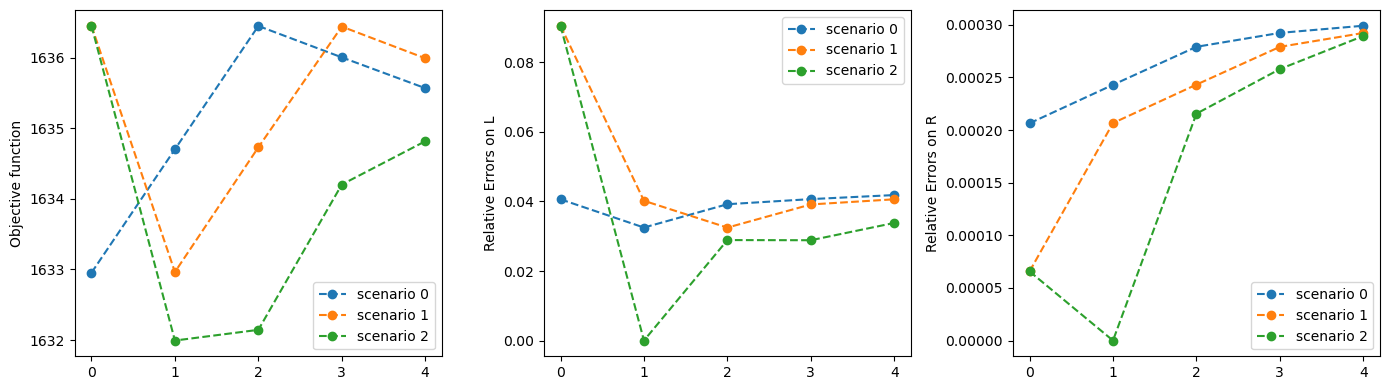

In [71]:
fig, axs = plt.subplots(1,3,figsize=(14,4))

axs[0].plot(various_objs.T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[0].set_ylabel("Objective function")
axs[0].legend()

axs[1].plot(Lerrors.T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[1].set_ylabel("Relative Errors on L")
axs[1].legend()


axs[2].plot(Rerrors.T, "--o", label=["scenario {}".format(i) for i in range(n_scenario)] )
axs[2].set_ylabel("Relative Errors on R")
axs[2].legend()

plt.tight_layout()

In [81]:
sc = 2
Lestims = various_Ls[sc]
Restims = various_Rs[sc]

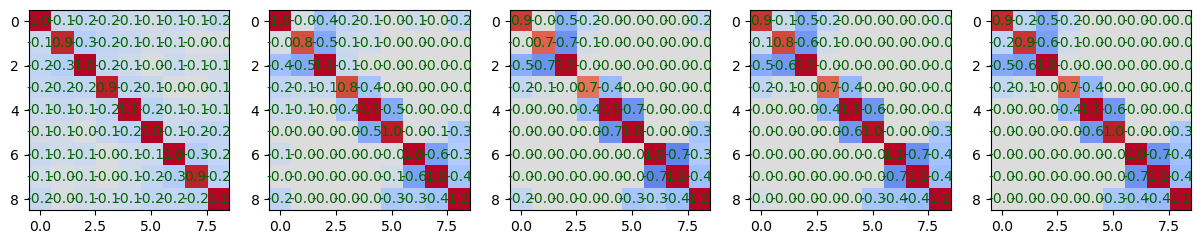

In [82]:
n = Lestims[0].shape[0]
fig, axs = plt.subplots(1, n_max_iter, figsize=(15,5), squeeze=False)
for L, ax in zip(Lestims, axs[0]):
    ax.imshow(L, cmap="coolwarm", vmin=-1, vmax=1)
    for i in range(n):
        for j in range(n):
            c = L[i,j]
            ax.text(i, j, "{:2.1f}".format(c), va='center', ha='center', color="darkgreen")

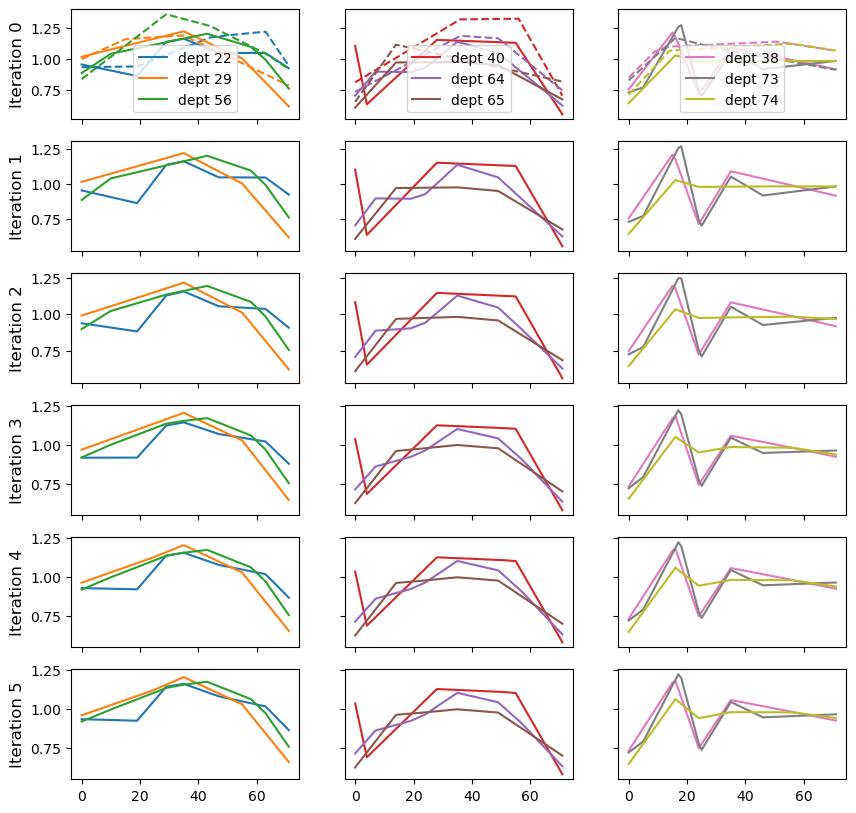

In [83]:
fig, axs = plt.subplots(n_max_iter+1, nclusters, figsize=(10,10), sharex=True, sharey="row", squeeze=False)
for i in range(n_max_iter+1):
    k = 0
    for j in range(nclusters):
        for l in range(cluster_sizes[j]):
            axs[i,j].plot(Restims[i][k], color=colors[k], label="dept "+names_by_clusters[j][l])
            # axs[i,j].plot(Restims[i][k], ':', color=colors[k])
            if i == 0:
                axs[i,j].plot(RestimUO[i][k], "--", color=colors[k])
            k+=1
        if i==0:
            axs[i,j].legend()
        if j==0:
            axs[i,j].set_ylabel("Iteration {}".format(i), fontsize=12)
plt.show()

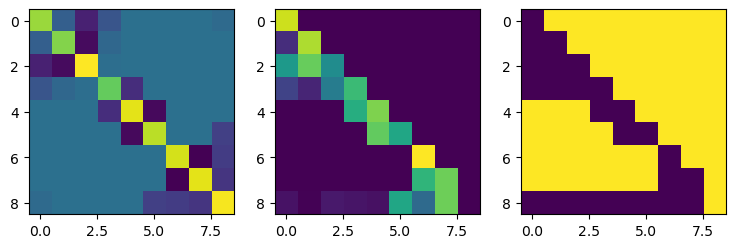

In [75]:
L = Lestims[3]
U = np.linalg.cholesky(L + (1e-12)*np.eye(L.shape[0]))
# plt.imshow( np.abs(U)<1e-10  )
fig, axs = plt.subplots(1,3, figsize=(9,3))
axs[0].imshow(L)
axs[1].imshow(np.abs(U))
axs[2].imshow(np.abs(U)/np.max(U)<1e-3)